# Calculate Surface Ocean Heat using CESM2 LENS data 

---

## Overview
- This notebook is an adpation of a [workflow](https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/Ocean-Heat-Content/OHC_tutorial.html) in the NCAR gallery of the Pangeo collection
- This notebook illustrates how to compute surface ocean heat content using potential temperature data from [CESM2 Large Ensemble Dataset](https://www.cesm.ucar.edu/community-projects/lens2) (Community Earth System Model 2) hosted on NCAR's GDEX.
- This data is open access and is accessed via OSDF using the pelicanFS package and demonstrates how you can stream data from NCAR's GDEX
- Please refer to the first chapter of this cookbook to learn more about OSDF, pelican or pelicanFS


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Intake-ESM](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | Used for searching CMIP6 data |
| [Understanding of Zarr](https://zarr.dev/) | Helpful | Familiarity with metadata structure |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Package used for plotting|
| [PelicanFS](https://projectpythia.org/osdf-cookbook/notebooks/pelicanfs/) | Necessary | The python package used to stream data in this notebook |
| OSDF| Helpful | OSDF is used to stream data in this notebook |

- **Time to learn**: 20 mins

---

## Imports

In [1]:
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import re
import matplotlib.pyplot as plt
import dask
from dask.distributed import LocalCluster
import pelicanfs 
import cf_units as cf

In [2]:
# Load Catalog URL
cat_url = 'https://stratus.gdex.ucar.edu/d010092/catalogs/d010092-osdf-zarr.json'

## Set up local dask cluster 

Before we do any computation let us first set up a local cluster using dask

In [3]:
cluster = LocalCluster()          
client = cluster.get_client()

In [4]:
# Scale the cluster
n_workers = 5
cluster.scale(n_workers)
cluster

LocalCluster(ac363fe2, 'tcp://127.0.0.1:41641', workers=4, threads=16, memory=15.16 GiB)

## Data Loading
### Load CESM2 LENS data from NCAR's GDEX
- Load CESM2 LENS zarr data from GDEx using an intake-ESM catalog that has OSDF links
- For more details regarding the dataset. See, https://gdex.ucar.edu/datasets/d010092/#

In [5]:
col = intake.open_esm_datastore(cat_url)
col

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [6]:
# Uncomment this line to see all the variables
# cesm_cat.df['variable'].values

In [7]:
cesm_temp = col.search(variable ='TEMP', frequency ='monthly')
cesm_temp

,unique
Unnamed: 0,3
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [8]:
cesm_temp.df['path'].values

array(['https://osdf-data.gdex.ucar.edu/ncar-gdex/d010092/ocn/monthly/cesm2LE-historical-cmip6-TEMP.zarr',
       'https://osdf-data.gdex.ucar.edu/ncar-gdex/d010092/ocn/monthly/cesm2LE-ssp370-cmip6-TEMP.zarr',
       'https://osdf-data.gdex.ucar.edu/ncar-gdex/d010092/ocn/monthly/cesm2LE-ssp370-smbb-TEMP.zarr'],
      dtype=object)

:::{note}
Note that all the file paths start with https://data-osdf.gdex.ucar.edu indicating that the data will be streamed via OSDF

In [9]:
dsets_cesm = cesm_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [10]:
dsets_cesm.keys()

dict_keys(['ocn.ssp370.monthly.smbb', 'ocn.ssp370.monthly.cmip6', 'ocn.historical.monthly.cmip6'])

In [11]:
historical       = dsets_cesm['ocn.historical.monthly.cmip6']
future_smbb      = dsets_cesm['ocn.ssp370.monthly.smbb']
future_cmip6     = dsets_cesm['ocn.ssp370.monthly.cmip6']

### Change units

In [12]:
orig_units = cf.Unit(historical.z_t.attrs['units'])
orig_units

Unit('centimeters')

In [13]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(orig_units.convert, ds[variable_bounds_str], target_units, dask='parallelized', output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units

In [14]:
depth_levels_in_m = change_units(historical, 'z_t', 'z_t', 'm')
hist_temp_in_degK = change_units(historical, 'TEMP', 'TEMP', 'degK')
fut_cmip6_temp_in_degK = change_units(future_cmip6, 'TEMP', 'TEMP', 'degK')
fut_smbb_temp_in_degK = change_units(future_smbb, 'TEMP', 'TEMP', 'degK')
#
hist_temp_in_degK  = hist_temp_in_degK.assign_coords(z_t=("z_t", depth_levels_in_m['z_t'].data))
hist_temp_in_degK["z_t"].attrs["units"] = "m"
hist_temp_in_degK

<xarray.DataArray (member_id: 50, time: 1980, z_t: 60, nlat: 384, nlon: 320)> Size: 3TB
dask.array<transpose, shape=(50, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t        (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon

In [15]:
depth_levels_in_m.isel(z_t=slice(0, -1))

<xarray.DataArray (z_t: 59)> Size: 236B
array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509840e+02, 1.7547905e+02, 1.8629128e+02, 1.9766028e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137016e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511923e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822763e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273672e+02, 5.2772803e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882526e+02, 9.8470587e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139717e+03,
       2.6490012e+03, 2.8893848e+03, 3.1334048e+03, 3.3797935e+03,
       3.6276704e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250283e+03], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 236B 500.0 1.5e+03 2.5e+03 ... 4.875e+05 5.125e+05

- Compute depth level deltas using the difference of z_t levels

In [16]:
depth_level_deltas = depth_levels_in_m.isel(z_t=slice(1, None)).values - depth_levels_in_m.isel(z_t=slice(0, -1)).values
# Optionally, if you want to keep it as an xarray DataArray, re-wrap the result
depth_level_deltas = xr.DataArray(depth_level_deltas, dims=["z_t"], coords={"z_t": depth_levels_in_m.z_t.isel(z_t=slice(0, -1))})
depth_level_deltas  

<xarray.DataArray (z_t: 59)> Size: 236B
array([ 10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.098404,  10.380646,  10.812225,  11.369003,  12.051102,
        12.866898,  13.830551,  14.961334,  16.284042,  17.829437,
        19.63559 ,  21.748749,  24.225494,  27.134155,  30.557007,
        34.59305 ,  39.35904 ,  44.991302,  51.644836,  59.489746,
        68.70068 ,  79.43921 ,  91.822754, 105.880615, 121.49835 ,
       138.36267 , 155.9303  , 173.44922 , 190.05688 , 204.94092 ,
       217.51233 , 227.51514 , 235.02954 , 240.38354 , 244.02002 ,
       246.38867 , 247.87695 , 248.7815  , 249.31616 , 249.62451 ,
       249.79785 , 249.89307 , 249.94482 , 249.97168 ], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 236B 500.0 1.5e+03 2.5e+03 ... 4.875e+05 5.125e+05

# Compute Ocean Heat content for ocean surface
- Ocean surface is considered to be the top 100m
- The formula for this is: $$ H = \rho C \int_0^z T(z) dz $$


Where H is ocean heat content, the value we are trying to calculate,

$\rho$ is the density of sea water, $1026 kg/m^3$  ,

$C$ is the specific heat of sea water, $3990 J/(kg K)$  ,

$z$ is the depth limit of the calculation in meters,

and $T(z)$ is the temperature at each depth in degrees Kelvin.

In [17]:
def calc_ocean_heat(delta_level, temperature):
    rho = 1026 #kg/m^3
    c_p = 3990 #J/(kg K)
    weighted_temperature = delta_level * temperature
    heat = weighted_temperature.sum(dim="z_t")*rho*c_p
    return heat

In [18]:
# Remember that the coordinate z_t still has values in cm
hist_temp_ocean_surface = hist_temp_in_degK.where(hist_temp_in_degK['z_t'] < 1e4,drop=True)
hist_temp_ocean_surface

<xarray.DataArray (member_id: 50, time: 1980, z_t: 10, nlat: 384, nlon: 320)> Size: 487GB
dask.array<where, shape=(50, 1980, 10, 384, 320), dtype=float32, chunksize=(1, 6, 10, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * z_t        (z_t) float32 40B 500.0 1.5e+03 2.5e+03 ... 8.5e+03 9.5e+03
Dimensions without coordinates: nlat, nlon

In [19]:
depth_level_deltas_surface = depth_level_deltas.where(depth_level_deltas['z_t'] <1e4, drop= True)
depth_level_deltas_surface

<xarray.DataArray (z_t: 10)> Size: 40B
array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)
Coordinates:
  * z_t      (z_t) float32 40B 500.0 1.5e+03 2.5e+03 ... 7.5e+03 8.5e+03 9.5e+03

In [20]:
hist_ocean_heat = calc_ocean_heat(depth_level_deltas_surface,hist_temp_ocean_surface)
hist_ocean_heat

<xarray.DataArray (member_id: 50, time: 1980, nlat: 384, nlon: 320)> Size: 49GB
dask.array<mul, shape=(50, 1980, 384, 320), dtype=float32, chunksize=(1, 6, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nlat, nlon

### Plot Ocean Heat

:::{attention}
 Has the surface ocean heat content increased with time due to Global Warming ? 
 Let us plot the difference between the annual, ensemble mean heat content between the years 2014 and 1850 to check!
:::

In [21]:
%%time
# Compute annual and ensemble mean
hist_oceanheat_ann_mean = hist_ocean_heat.mean('member_id').groupby('time.year').mean()
hist_oceanheat_ann_mean 

CPU times: user 461 ms, sys: 16.8 ms, total: 478 ms
Wall time: 454 ms


<xarray.DataArray (year: 165, nlat: 384, nlon: 320)> Size: 81MB
dask.array<stack, shape=(165, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
Dimensions without coordinates: nlat, nlon

In [22]:
hist_oceanheat_ano = \
hist_oceanheat_ann_mean.sel(year=2014) - hist_oceanheat_ann_mean.sel(year=1850)

CPU times: user 6.19 s, sys: 565 ms, total: 6.75 s
Wall time: 34.5 s


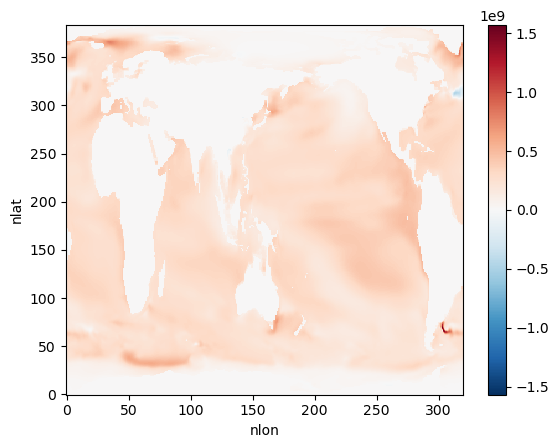

In [23]:
%%time
hist_oceanheat_ano.plot()

Indeed! The surface ocean is trapping heat as the globe warms! 

---

## Summary
In this notebook we used sea temperature data from the Community Earth System Model (CESM2) Large Ensemble dataset to compute surface ocean heat and convince ourselves that the surface ocean is trapping extra heat as the globe warms. We used an intake-ESM catalog backed by pelican links to stream data from NCAR's Geoscience Data Exchange via NCAR's OSDF origin!

### What's next?
In the next notebook, we will see how to load data from multiple OSDF origins into a workflow. We will stream CMIP6 model data from AWS and observational data from NCAR's GDEX.

## Resources and references
- Original [notebook](https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/Ocean-Heat-Content/OHC_tutorial.html) on the pangeo NCAR gallery
- [CESM2 Large Ensemble Dataset](https://www.cesm.ucar.edu/community-projects/lens2) (Community Earth System Model 2) hosted on NCAR's GDEX.